In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pdb

from torch.autograd import Variable
import torch.nn.functional as F

import gym
import cv2
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from rq import Queue
from redis import Redis
import PIL
from tqdm import tqdm

from IPython.display import HTML, display
import imageio
import random
import sys
import os
import time
import pickle
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ga_model import *

def to_np(x):
    return x.data.cpu().numpy()

Automatic pdb calling has been turned ON
Successfully imported mkl...


# Gym stuff

In [2]:
env = gym.make('SpaceInvadersDeterministic-v4')

Discrete(6)


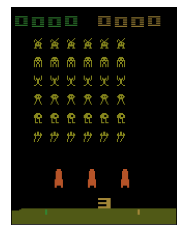

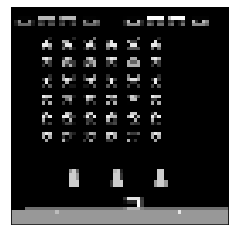

In [3]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if len(im.shape) == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def render(env, converted=False):
    state = env.render(mode='rgb_array')
    if converted:
        state = convert_state(state)
    plt.show(show_img(state))
    
reset(env)
print(env.action_space)
render(env)
render(env, converted=True)

# Model

> We use the larger DQN architecture from Mnih et al. (2015) consisting of 3 convolutional layers with 32, 64, and 64 channels followed by a hidden layer
with 512 units. The convolutional layers use 8 × 8, 4 × 4, and 3 × 3 filters with strides of 4, 2, and 1, respectively. All hidden layers were followed by a rectifier nonlinearity (ReLU). The network contains over 4M parameters.

In [4]:
states = []
for _ in range(4):
    states.append(step(env, env.action_space.sample())[0])

In [5]:
m = Model(random_state())
print('first try')
print(to_np(m(Variable(torch.Tensor([states])))))
print('didn\'t change anything, should be the same')
print(to_np(m(Variable(torch.Tensor([states])))))
m.evolve(0.005, random_state())
print('after evolution, should be different but only slightly')
print(to_np(m(Variable(torch.Tensor([states])))))

m2 = uncompress_model(m.compress())
print('copied model, should be the same')
print(to_np(m2(Variable(torch.Tensor([states])))))


first try
[[-0.11938027 -0.01120389 -0.08198363  0.48182204  0.01563491  0.12691252
   0.01460972 -0.11233878 -0.16250661 -0.17245854  0.30552512  0.29131344
  -0.05324591 -0.18312193 -0.08419135  0.0079508   0.11080994 -0.07513968]]
didn't change anything, should be the same
[[-0.11938027 -0.01120389 -0.08198363  0.48182204  0.01563491  0.12691252
   0.01460972 -0.11233878 -0.16250661 -0.17245854  0.30552512  0.29131344
  -0.05324591 -0.18312193 -0.08419135  0.0079508   0.11080994 -0.07513968]]
after evolution, should be different but only slightly
[[-0.1504919  -0.06204033 -0.15670903  0.44600552 -0.00590044  0.129473
  -0.04256814 -0.10215352 -0.11600465 -0.1532413   0.31674138  0.2831133
  -0.03908978 -0.17235067 -0.0462168   0.07322099  0.12549455 -0.03350411]]
copied model, should be the same
[[-0.1504919  -0.06204033 -0.15670903  0.44600552 -0.00590044  0.129473
  -0.04256814 -0.10215352 -0.11600465 -0.1532413   0.31674138  0.2831133
  -0.03908978 -0.17235067 -0.0462168   0.0732

/home/ubuntu/neuroevo/ga_model.py:45: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(tensor)


Ok great, it compiles.

# GA

In [6]:
REDIS_HOST = '172.31.33.192' # '172.31.2.229'
TIMEOUT = 3000  # orig value is 600
TTL = TIMEOUT + 50

class FakeJob:
    def __init__(self, j):
        self.result = j.result

class GA:
    def __init__(self, population, compressed_models=None, queue_name='default'):
        self.population = population
        self.models = [CompressedModel() for _ in range(population)] if compressed_models is None else compressed_models
        
        self.redis = Redis(REDIS_HOST)
        self.queue = Queue(connection=self.redis, name=queue_name)
        for j in self.queue.jobs:
            j.cancel()

    # Note: the paper says "20k frames", but there are 4 frames per network
    # evaluation, so we cap at 5k evaluations
    def get_best_models(self, env, max_eval=5000, max_noop=30):  # max_eval=5000
        jobs = []
        for m in self.models:
            jobs.append(self.queue.enqueue(evaluate_model, env, m, max_eval=max_eval, max_noop=max_noop, ttl=TTL, job_timeout=TIMEOUT))
        last_enqueue_time = time.time()
        while True:
            for i in range(len(jobs)):
                if jobs[i].result is not None and not isinstance(jobs[i], FakeJob):
                    if random.random() < 0.001:
                        print(jobs[i].result)
                    jobs[i] = FakeJob(jobs[i])
                    
            def convert_result(j):
                if j.result is not None:
                    if j.result[0] == 0.0 and j.result[1] == max_eval * 4 and 'Breakout' in env:
                        return -1.0
                    return j.result[0]
                return None
            scores = [convert_result(j) for j in jobs]
            if None not in scores:
                break
            if time.time() - last_enqueue_time > TIMEOUT:
                print(f'Reenqueuing unfinished jobs ({sum(x is None for x in scores)}).')
                for i in range(len(jobs)):
                    if jobs[i].result is None:
                        jobs[i].cancel()
                        jobs[i] = self.queue.enqueue(
                            evaluate_model, env, self.models[i], max_eval=max_eval, max_noop=max_noop, ttl=TTL, job_timeout=TIMEOUT)
                last_enqueue_time = time.time()
            time.sleep(1)
        used_frames = sum(j.result[1] for j in jobs)
        scored_models = list(zip(self.models, scores))
        scored_models.sort(key=lambda x: x[1], reverse=True)
        return scored_models, used_frames

    def evolve_iter(self, env, sigma=0.005, truncation=5000, max_eval=5000, max_noop=30, num_elites=1):
        # Change: set truncation to population size -- no truncation; letting repro_weights take care of this
        # original value: 10
        
        if num_elites > truncation:
            num_elites = truncation
            print('Invalid argument choice: num_elites > truncation.'
                  'If an agent is fit enough to be elite, it should also be fit enough to reproduce')
        scored_models, used_frames = self.get_best_models(env, max_eval=max_eval, max_noop=max_noop)
        scores = [s for _, s in scored_models]
        median_score = np.median(scores)
        mean_score = np.mean(scores)
        max_score = scored_models[0][1]
        scored_models = scored_models[:truncation]
        
        # Elitism
        self.models = [scored_models[i][0] for i in range(num_elites)] # Allow num_elites > 1
        for i in range(self.population - num_elites + 1):
            # Weight parents by score when choosing which ones reproduce
            repro_weights = [scored_model[1] for scored_model in scored_models]
            random_parent = random.choices(list(enumerate(scored_models)), weights=repro_weights)[0]
            random_parent_model = random_parent[1][0]
            random_parent_score = random_parent[1][1]
            random_parent_idx = random_parent[0]
            self.models.append(copy.deepcopy(random_parent_model))
            # Use parent score to compute noise? Here, just using parent index.
            self.models[-1].evolve(sigma * (random_parent_idx + 1) / truncation * 100 )
            
        return median_score, mean_score, max_score, used_frames


In [7]:
def make_video(env, model, max_eval=2000, max_noop=30):  # max_eval=200000 orig value.
    env = gym.make(env)
    model = uncompress_model(model)
    noops = random.randint(0, max_noop)
    cur_states = [reset(env)] * 4
    total_reward = 0
    frames = [env.render(mode='rgb_array')]
    for _ in range(noops):
        cur_states.pop(0)
        new_state, reward, is_done, _ = step(env, 0)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            return total_reward
        cur_states.append(new_state)

    print('done noops in make_video')
    model.eval()
    for _ in tqdm(range(max_eval)):
        values = model(Variable(torch.Tensor([cur_states])))[0]
        action = np.argmax(values.data.numpy()[:env.action_space.n])
        new_state, reward, is_done, _ = step(env, action)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            break
        cur_states.pop(0)
        cur_states.append(new_state)

    print("done make_video")
    return total_reward, frames

In [8]:
def run_env(env, do_run=True, render_vids=True):
    if do_run:
        ga = GA(5000)  # 5000

        total_frames = 0
        all_results = [(0.0, 0.0, 0.0, 0, time.time())]
        while total_frames < 1_000_000_000: # 100_000_000 to run faster...
            print(f'total_frames={total_frames}')
            if 'Breakout' in env.spec.id and total_frames < 10_000_000:
                med, avg, M, frames = ga.evolve_iter(env.spec.id, max_eval=400)
            else:
                med, avg, M, frames = ga.evolve_iter(env.spec.id)
            total_frames += frames
            all_results.append((med, avg, M, frames, time.time()))
            print(f'Done with generation!\nMedian: {med}, average: {avg}, max: {M}, frames: {total_frames:,}')
        print('getting best_models')
        best_models = ga.get_best_models(env.spec.id)[0]
        print('DONE getting best_models')
        pickle.dump(all_results, open(f'{env.spec.id}_process.pickle', 'wb'))
        pickle.dump(best_models, open(f'{env.spec.id}_best.pickle', 'wb'))
        
    
    
    best_models = pickle.load(open(f'{env.spec.id}_best.pickle', 'rb'))
    print('got best models')
    process = pickle.load(open(f'{env.spec.id}_process.pickle', 'rb'))
    print('got _process')
    
    if render_vids:
        videos = [make_video(env.spec.id, best_models[0][0]) for _ in range(3)]  # orig 30 videos
        print('got videos array')
        pickle.dump(videos, open(f'{env.spec.id}_videos.pickle', 'wb'))
        print('dumped to _videos.pickle')
    print('done if render_vids')
    videos = pickle.load(open(f'{env.spec.id}_videos.pickle', 'rb'))
    print('got _videos.pickle')
    
    def convert_vid(video):
        res = []
        for v in video:
            img = PIL.Image.fromarray(v)
            img = img.resize((320, 240))
            res.append(np.array(img))
        return res
    
    videos = [(s, convert_vid(v)) for s, v in videos]
    videos.sort(key=lambda x:x[0])
    best_score, best_vid = videos[-1]
    worst_score, worst_vid = videos[0]
    median_score, median_vid = videos[len(videos) // 2]
    print(f'Best score: {best_score}')
    gif_file = f'{env.spec.id}_best.gif'
    imageio.mimsave(gif_file, best_vid + [best_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    print(f'Worst score: {worst_score}')
    gif_file = f'{env.spec.id}_worst.gif'
    imageio.mimsave(gif_file, worst_vid + [worst_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    print(f'Median score: {median_score}')
    gif_file = f'{env.spec.id}_median.gif'
    imageio.mimsave(gif_file, median_vid + [median_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    for idx, name in enumerate(['Median Score', 'Average Score', 'Max Score', 'Frames Per Run', 'Total Time']):
        if name == 'Frames':
            div = 5000
        else:
            div = 1
        sb.set_style("darkgrid")
        plt.plot(list(range(1, len(process))), [(p[idx] - process[0][idx]) / div for p in process[1:]])
        plt.xlabel('Generation')
        plt.ylabel(name)
        plt.savefig(f'{env.spec.id}_{name}.png')
        plt.show()


## Let's look at the results!

Finally, it's one or two hours later, depending on how many machines you chose to use, and we have results!

So how do we evaluate the performance of our agents? Well, Uber has a few things to say about that:
> Comparing our results with those from other algorithms fairly is extremely difficult, as such comparisons are inherently apples and oranges in many different ways. One important consideration is whether agents are evaluated on random starts (a random number of no-op actions), which is the regime they are trained on, or starts randomly sampled from human play, which tests for generalization (Nair et al., 2015). **Because we do not have a database of human starts to sample from**, our agents are evaluated with random starts. Where possible, we compare our results to those for other algorithms for which such random start results are available. That is true for DQN and ES, but not true for A3C, where we had to include results on human starts.

The emphasis on lacking a database of human starts is mine: I think this is too bad, and indeed there does not seem to be such a database and I think it would be great to build one.

Regardless, it sounds like the way we should evaluate our agent is simply using a random number of no-op operations before starting them, which is how we did training in the first place. The number of no-ops is not specified here but it is given as between 0 and 30 elsewhere, so that's what we'll do. Because there is this randomness aspect (not to mention the potential for random number generation within the individual Atari games), I decided to run the game 30 times and to display the best, worst, and median result. Here goes, for Frostbite:

<TimeLimit<AtariEnv<FrostbiteDeterministic-v4>>>
FrostbiteDeterministic-v4
total_frames=0
(0.0, 952)
(10.0, 1136)
Done with generation!
Median: 0.0, average: 38.006, max: 810.0, frames: 41,114,840
total_frames=41114840
(80.0, 1188)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 1052)
Done with generation!
Median: 40.0, average: 67.96640671865627, max: 1320.0, frames: 71,816,500
total_frames=71816500
(1150.0, 2940)
(80.0, 1168)
(0.0, 20000)
(70.0, 1260)
(0.0, 924)
(0.0, 20000)
Done with generation!
Median: 40.0, average: 80.77384523095381, max: 2030.0, frames: 101,507,216
total_frames=101507216
(90.0, 1460)
(70.0, 1160)
(0.0, 20000)
(190.0, 2396)
(80.0, 2000)
(0.0, 20000)
Done with generation!
Median: 60.0, average: 110.06598680263947, max: 2390.0, frames: 128,470,820
total_frames=128470820
(110.0, 1884)
(80.0, 1208)
Done with generation!
Median: 80.0, average: 135.56688662267547, max: 2390.0, frames: 153,745,532
total_frames=153745532
(200.0, 1976)
(200.0, 1744)

  1%|          | 15/2000 [00:00<00:13, 148.06it/s]

done noops in make_video


 19%|█▉        | 381/2000 [00:02<00:10, 155.81it/s]


done make_video


  1%|          | 17/2000 [00:00<00:12, 164.58it/s]

done noops in make_video


 34%|███▍      | 682/2000 [00:04<00:08, 161.24it/s]


done make_video


  1%|          | 17/2000 [00:00<00:12, 160.41it/s]

done noops in make_video


 53%|█████▎    | 1063/2000 [00:06<00:05, 156.87it/s]


done make_video
got videos array
dumped to _videos.pickle
done if render_vids
got _videos.pickle
Best score: 1790.0


Worst score: 120.0


Median score: 930.0


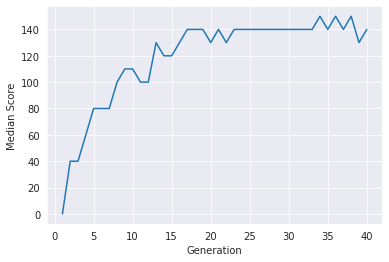

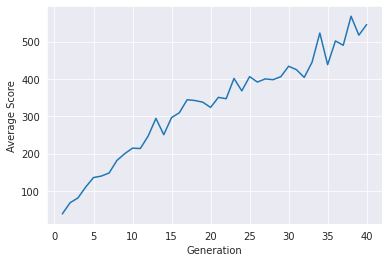

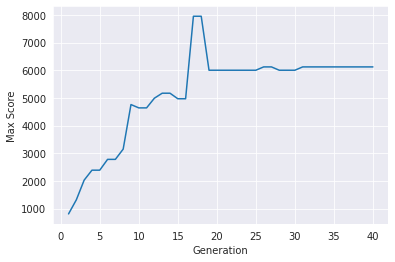

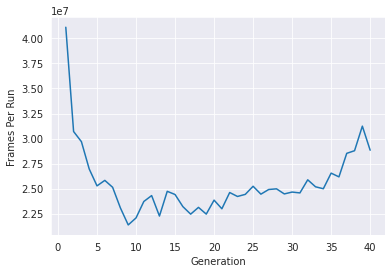

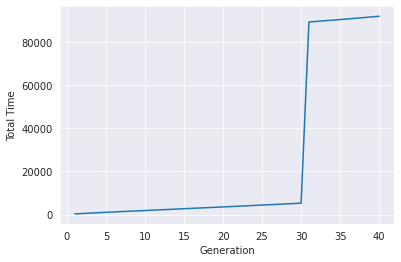

In [9]:
myenv = gym.make('FrostbiteDeterministic-v4')
print(myenv)
print(myenv.spec.id)
# run_env(myenv, False, render_vids=True)
run_env(myenv, True, render_vids=True)

In [10]:
print('bye')

bye


## Frostbite

We can see that we get an agent that performs very well for Frostbite: 4,570 as its best score, which is close to Uber's 4,801, and which is roughly the state of the art right now as far as I know! Very exciting.

Unfortunately, as we can see, the agent is not at all robust even to random starts! The median score is only 170 and the worst score is 160! It isn't clear to me why Uber did not report this: is it an issue in my implementation? Something that happened to them as well but that they failed to report? An issue in their implementation? (if they implemented random starts badly for instance, this might not be visible). 

This seems to explain the extremely large discrepancy between the median score and the best score as I go through generations (Uber's graph of "median" scores are not using this definition, which is why I can't really compare them to what I found: in Uber's definition it is the median of the best agent across multiple runs): it is not that agents are very sensitive to small changes in their weights, it is that they are very sensitive to small changes in their starting point!

I am really interested in fixing this issue in the future. In my mind, there are two things that could help fix this:
* Evaluating each neural net not on a single run but on several, each of which start with a different number of no-ops.
* Revisiting epsilon greedy for genetic algorithms: this seems crazy because it doesn't seem like GA "need" an exploration strategy, which is why Uber didn't implement one, but it could be that exploration doesn't just help reinforcement learning agents only with finding new high-reward states, but also with becoming robust to finding themselves in unforseen situations. Right now it seems like the GA networks are overfitting to a very specific sequence of actions from the game.

In [ ]:
run_env(gym.make('BreakoutDeterministic-v4'), True, render_vids=True)

total_frames=0
(0.0, 1600)
(0.0, 1600)
(0.0, 1600)
(0.0, 1600)
(0.0, 1600)
Done with generation!
Median: -1.0, average: -0.721, max: 3.0, frames: 6,639,176
total_frames=6639176
(0.0, 488)
(0.0, 1600)
(0.0, 488)
(0.0, 1600)
(3.0, 984)
(2.0, 1600)
Done with generation!
Median: 3.0, average: 1.687862427514497, max: 4.0, frames: 12,658,544
total_frames=12658544
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(0.0, 488)
(0.0, 20000)
Done with generation!
Median: -1.0, average: -0.6264747050589882, max: 4.0, frames: 82,048,120
total_frames=82048120
(4.0, 1132)
(4.0, 1132)
(4.0, 1132)
(4.0, 1132)
Done with generation!
Median: 4.0, average: 3.1027794441111776, max: 7.0, frames: 101,148,224
total_frames=101148224
(0.0, 488)
(0.0, 488)
(0.0, 488)
(0.0, 20000)
(0.0, 20000)
Done with generation!
Median: 0.0, average: -0.27794441111777646, max: 7.0, frames: 148,522,868
total_frames=148522868
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.0, 992)
(7.

### Breakout

Oh boy... GAs do **terribly** on Breakout. Why?

I can see a few reasons:
* You need to run a specific action or breakout won't start (specifically, breakout has 4 actions: do nothing, start the game, move left and move right).
 * This is not a problem when following a randomized exploration strategy such as epsilon-greedy, because the action will get chosen at some point or other, but without any exploration at all, it means that a large proportion of agents will simply do nothing forever.
 * To prevent this, I even made sure to reduce the maximum length of a game in the first few generations and to penalize agents that had done nothing at all the whole time. Obviously it didn't work that well, however.
* Very few of the pixels change in breakout, so agents keep performing the same action.
 * In Frostbite, almost 50% of the pixels are guaranteed to change even if the agent does nothing. In Breakout, only a tiny ball, the paddle, and maybe a brick or two will change, and only if the agent actually does something. For a randomly initialized neural network, this is likely not enough for it to decide to perform a different action.
 
Again, I think there are ways to fix this issue, including again including epsilon-greedy exploration in training. This warrants further exploration.

In [ ]:
run_env(gym.make('SpaceInvadersDeterministic-v4'), True, render_vids=True)

### Space Invaders

The agent does relatively well on space invaders, similar to the agent we trained in https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c, which is far from state of the art, but still pretty decent. Besides, it actually performs the same regardless of the initial random no-ops.

However, I am a bit concered about its strategy which consists, at least at first, in simply staying far to the left and trying to shoot the mothership: this looks more like a weird local optimum than an actual skill that the agent has obtained. Again I am curious what would make it learn something that looks more like real skill at the game and not a lazy strategy.

## Conclusion

I am excited about the results in Uber's paper. The fact that it does so well at Frostbite is quite amazing, and it is unclear to me if this means that traditional RL algorithms are particularly weak or that GA is surprisingly strong. I think, however, that there seem to be significant issues with GA that Uber doesn't point out, partly because they weren't able to evaluate their algorithms using a human-start database (which I think would have shown the brittleness of the various agents), and it would be interesting to try to fix these. I for one plan to try including epsilon-greedy exploration in the future, which I think will help with the robustness of the agents, and as Uber points out, there is a ton of literature available on genetic algorithms, and they only tried the most basic possible ones. Who knows where more advanced GAs will take us.